In [29]:
%reload_ext autoreload
%autoreload 2

import numpy as np
from matplotlib import pyplot as plt
from scipy.signal import filtfilt
from src.iaf.experiments import get_correlated_experiment, get_ica_experiment

apical_dp_ratio = 1.075
experiment = "correlated"
if experiment == "correlated":
    sim, cfg = get_correlated_experiment(apical_dp_ratio)
elif experiment == "ica":
    sim, cfg = get_ica_experiment(apical_dp_ratio)
else:
    raise ValueError(f"Experiment {experiment} not found")

In [30]:
out = sim.run(duration=100)

100%|██████████| 100/100 [00:07<00:00, 13.66it/s]


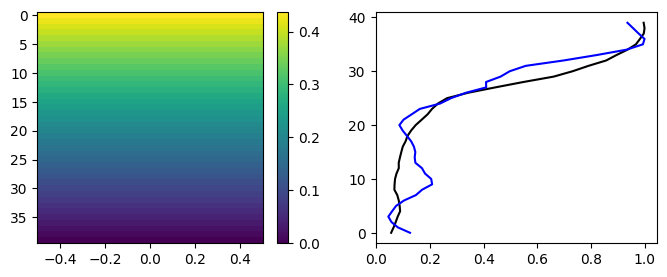

In [26]:
plt.figure(1, figsize=(8, 3))

plt.subplot(1, 2, 1)
im = plt.imshow(sim.source_populations["excitatory"].source_loading.T, aspect='auto', interpolation="none")
plt.colorbar(im)

plt.subplot(1, 2, 2)
smooth_factor = round(sim.source_populations["excitatory"].num_inputs/sim.source_populations["excitatory"].num_signals/10)
kernel = np.ones(smooth_factor) / smooth_factor
saw = filtfilt(kernel, 1, out["weights"]["basal"][-1])
max_weight = np.max(saw)
plt.plot(saw/max_weight, range(sim.source_populations["excitatory"].num_inputs-1, -1, -1), 'k', linewidth=1.5, label="High DP")

smooth_factor = round(sim.source_populations["excitatory"].num_inputs/sim.source_populations["excitatory"].num_signals/10)
kernel = np.ones(smooth_factor) / smooth_factor
saw = filtfilt(kernel, 1, out["weights"]["apical"][-1])
max_weight = np.max(saw)
plt.plot(saw/max_weight, range(sim.source_populations["excitatory"].num_inputs-1, -1, -1), 'b', linewidth=1.5, label="Low DP")

plt.show()

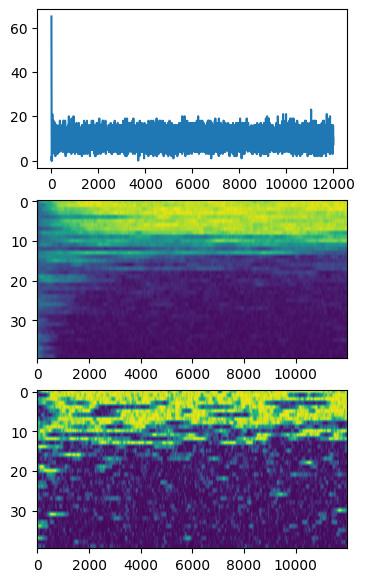

In [27]:
# Create spike train and PSTH
duration = out["weights"]["basal"].shape[0]
NT = int(duration / sim.dt)
dt = sim.dt
psth_window = 1  # in seconds
dpsth = round(psth_window/dt)
spikes = np.zeros(NT)
spikes[out["spike_times"]] = 1
psth = np.sum(spikes.reshape(-1, dpsth), axis=1)/psth_window
tvec = np.arange(NT) * dt + dt

# Create plots
plt.figure(1, figsize=(4, 7))
plt.subplot(3, 1, 1)
plt.plot(range(1, len(psth) + 1), psth)
plt.subplot(3, 1, 2)
plt.imshow(out["weights"]["basal"].T, aspect='auto')
plt.subplot(3, 1, 3)
plt.imshow(out["weights"]["apical"].T, aspect='auto')
plt.show()

In [6]:
from time import perf_counter as tic
from src.files import get_config_path
from src.iaf.config import SimulationConfig
from src.iaf.simulation import Simulation

config = SimulationConfig.from_yaml(get_config_path("correlated.yaml"))

In [2]:
from copy import deepcopy
from src.iaf.source_population import SourcePopulationCorrelation, SourcePopulationPoisson
from src.iaf.iaf_neuron import IaF
from src.iaf.synapse_group import SourcedSynapseGroup, DirectSynapseGroup

source_populations = {
    "excitatory": SourcePopulationCorrelation.from_config(config.sources["excitatory"]),
    "inhibitory": SourcePopulationPoisson.from_config(config.sources["inhibitory"]),
}

neuron = IaF.from_config(config.neuron)
neuron_for_array = deepcopy(neuron)

synapses = {
    "basal": SourcedSynapseGroup.from_config(config.synapses["basal"]),
    "apical": SourcedSynapseGroup.from_config(config.synapses["apical"]),
    "inhibitory": DirectSynapseGroup.from_config(config.synapses["inhibitory"]),
}

sim = Simulation(source_populations, neuron, synapses)
sims = Simulations(source_populations, neuron_for_array, synapses, num_simulations=3)

In [11]:
duration = 800
outs = sims.run(duration=duration)

100%|██████████| 800/800 [02:23<00:00,  5.57it/s]


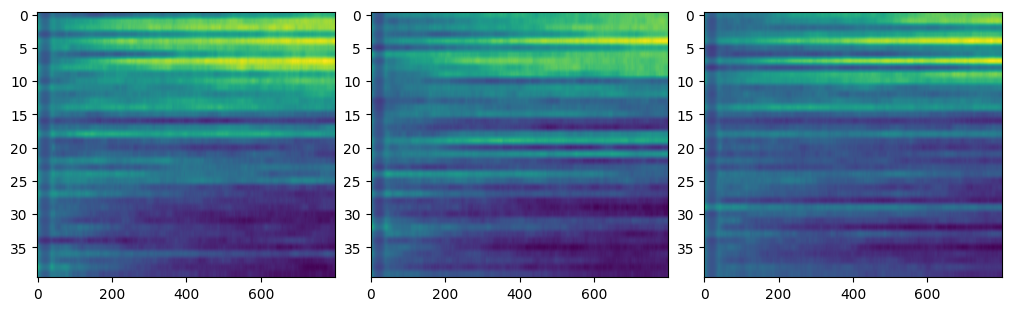

In [12]:
from matplotlib import pyplot as plt

fig, ax = plt.subplots(1, len(sims.neurons), figsize=(10, 3), layout="constrained")
for i, neuron in enumerate(sims.neurons):
    ax[i].imshow(outs["weights"][i]["basal"].T, aspect='auto')
plt.show()


In [16]:
import joblib
from src.files import root_dir

In [18]:
def results_dir(folder: str | None = None):
    directory = root_dir() / "results"
    if folder is not None:
        directory = directory / folder
    if not directory.exists():
        directory.mkdir(parents=True, exist_ok=True)
    return directory

rd = results_dir("iaf_correlated")

PosixPath('/Users/landauland/Documents/GitHub/plasticy-modeling/results/iaf_correlated')